# Dataset Analysis

In [ ]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

from tqdm import tqdm

In [2]:
# Load the CSV
labels_df = pd.read_csv("dataset_project_iapr2025/train.csv", index_col="id")
class_names = labels_df.columns.tolist()

In [3]:
labels_df

,Jelly White,Jelly Milk,Jelly Black,Amandina,Crème brulée,Triangolo,Tentation noir,Comtesse,Noblesse,Noir authentique,Passion au lait,Arabia,Stracciatella
id,,,,,,,,,,,,,
1000756,2,0,0,0,0,1,0,0,1,0,0,0,2
1000763,2,3,3,0,0,0,0,0,0,0,0,0,0
1000765,0,0,0,0,0,3,0,0,0,0,2,0,0
1000768,0,0,0,0,0,0,0,1,1,0,0,0,2
1000772,3,2,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010031,0,0,0,0,0,0,2,0,2,0,2,2,0
1010032,0,0,0,0,0,2,2,2,0,0,0,0,0
1010035,0,0,0,0,0,3,0,0,3,2,0,0,0


In [4]:
class_names

['Jelly White',
 'Jelly Milk',
 'Jelly Black',
 'Amandina',
 'Crème brulée',
 'Triangolo',
 'Tentation noir',
 'Comtesse',
 'Noblesse',
 'Noir authentique',
 'Passion au lait',
 'Arabia',
 'Stracciatella']

In [5]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Keep it light
    transforms.ToTensor(),
])

In [6]:
class ChocolateDataset(Dataset):
    def __init__(self, img_dir, df, transform=None):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform
        self.img_ids = df.index.tolist()
        # print(self.img_ids)
        self.labels = df.values.astype("float32")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, f"L{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
# Split
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

train_dataset = ChocolateDataset("dataset_project_iapr2025/train", train_df, transform=transform)
val_dataset = ChocolateDataset("dataset_project_iapr2025/train", val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [8]:
train_dataset.img_ids

[1000916,
 1000964,
 1000993,
 1000981,
 1010008,
 1000859,
 1000872,
 1000793,
 1000974,
 1000977,
 1000866,
 1010004,
 1000791,
 1000979,
 1000779,
 1000896,
 1000910,
 1000808,
 1000903,
 1000875,
 1000785,
 1010012,
 1000850,
 1000815,
 1010029,
 1000843,
 1000930,
 1000799,
 1000831,
 1000768,
 1000810,
 1000885,
 1000788,
 1010035,
 1000780,
 1000971,
 1000880,
 1010015,
 1010045,
 1000932,
 1000899,
 1000923,
 1000909,
 1000963,
 1010041,
 1000804,
 1000992,
 1000894,
 1000951,
 1000914,
 1010014,
 1000946,
 1000870,
 1010031,
 1000952,
 1000965,
 1010009,
 1000882,
 1000854,
 1000763,
 1000928,
 1000826,
 1000765,
 1000828,
 1010026,
 1001000,
 1010022,
 1000817,
 1000957,
 1000989,
 1000802,
 1000926]

In [9]:
class ChocolateCounterCNN(nn.Module):
    def __init__(self, num_classes=13):
        super(ChocolateCounterCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
            nn.ReLU()  # Count can't be negative
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChocolateCounterCNN().to(device)
criterion = nn.MSELoss()  # or nn.SmoothL1Loss() for robustness to outliers
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def custom_f1_score(y_true, y_pred):
    """Compute image-wise average F1 score based on counts"""
    eps = 1e-7
    f1_scores = []
    for true, pred in zip(y_true, y_pred):
        TP = np.sum(np.minimum(true, pred))
        FP_N = np.sum(np.abs(true - pred))
        if TP + FP_N == 0:
            f1 = 1.0  # perfect zero prediction
        else:
            f1 = (2 * TP) / (2 * TP + FP_N + eps)
        f1_scores.append(f1)
    return np.mean(f1_scores)


In [27]:
EPOCHS = 30

train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
train_exact_acc = []
val_exact_acc = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    total_train_loss = 0
    total_train_f1 = 0
    total_train_exact_match = 0
    num_train_batches = 0
    num_train_samples = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1
        num_train_samples += labels.size(0)

        # Predictions rounded to nearest integer
        preds = torch.round(outputs).detach().cpu().numpy().astype(int)
        targets = labels.detach().cpu().numpy().astype(int)

        # F1 Score (macro)
        f1 = custom_f1_score(targets, preds)
        total_train_f1 += f1

        # Exact match accuracy
        exact_matches = np.all(preds == targets, axis=1)
        total_train_exact_match += np.sum(exact_matches)

    avg_train_loss = total_train_loss / num_train_batches
    avg_train_f1 = total_train_f1 / num_train_batches
    avg_train_exact_acc = total_train_exact_match / num_train_samples

    train_losses.append(avg_train_loss)
    train_f1s.append(avg_train_f1)
    train_exact_acc.append(avg_train_exact_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {avg_train_loss:.4f}, Train F1: {avg_train_f1:.4f}, "
          f"Train Exact Acc: {avg_train_exact_acc:.2%}")


    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_f1 = 0
    total_val_exact_match = 0
    num_val_batches = 0
    num_val_samples = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            num_val_batches += 1
            num_val_samples += labels.size(0)
            
            preds = torch.round(outputs).detach().cpu().numpy().astype(int)
            targets = labels.detach().cpu().numpy().astype(int)

            # F1 Score (macro)
            f1 = custom_f1_score(targets, preds)
            total_val_f1 += f1

            # Exact match accuracy
            exact_matches = np.all(preds == targets, axis=1)
            total_val_exact_match += np.sum(exact_matches)

        # Compute average metrics
    avg_val_loss = total_val_loss / num_val_batches
    avg_val_f1 = total_val_f1 / num_val_batches
    avg_val_exact_acc = total_val_exact_match / num_val_samples

    # Append metrics to lists for plotting
    val_losses.append(avg_val_loss)
    val_f1s.append(avg_val_f1)
    val_exact_acc.append(avg_val_exact_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - "
            f"Val Loss: {avg_val_loss:.4f}, Val F1: {avg_val_f1:.4f}, "
            f"Val Exact Acc: {avg_val_exact_acc:.2%}")

100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


Epoch 1/30 - Train Loss: 0.4795, Train F1: 0.5146, Train Exact Acc: 0.00%


100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 1/30 - Val Loss: 0.8164, Val F1: 0.0980, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


Epoch 2/30 - Train Loss: 0.4379, Train F1: 0.5636, Train Exact Acc: 0.00%


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 2/30 - Val Loss: 0.8687, Val F1: 0.1404, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


Epoch 3/30 - Train Loss: 0.3795, Train F1: 0.6003, Train Exact Acc: 0.00%


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 3/30 - Val Loss: 0.9103, Val F1: 0.1506, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


Epoch 4/30 - Train Loss: 0.3411, Train F1: 0.6317, Train Exact Acc: 1.39%


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch 4/30 - Val Loss: 0.8604, Val F1: 0.1248, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


Epoch 5/30 - Train Loss: 0.2881, Train F1: 0.6825, Train Exact Acc: 1.39%


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Epoch 5/30 - Val Loss: 0.9561, Val F1: 0.1115, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


Epoch 6/30 - Train Loss: 0.2490, Train F1: 0.7240, Train Exact Acc: 5.56%


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Epoch 6/30 - Val Loss: 0.9009, Val F1: 0.0874, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


Epoch 7/30 - Train Loss: 0.2235, Train F1: 0.7490, Train Exact Acc: 6.94%


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


Epoch 7/30 - Val Loss: 0.9740, Val F1: 0.1387, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


Epoch 8/30 - Train Loss: 0.2088, Train F1: 0.7729, Train Exact Acc: 2.78%


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


Epoch 8/30 - Val Loss: 0.9708, Val F1: 0.1207, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


Epoch 9/30 - Train Loss: 0.2251, Train F1: 0.7735, Train Exact Acc: 9.72%


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


Epoch 9/30 - Val Loss: 0.9834, Val F1: 0.1386, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


Epoch 10/30 - Train Loss: 0.2279, Train F1: 0.7697, Train Exact Acc: 9.72%


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Epoch 10/30 - Val Loss: 0.9627, Val F1: 0.1490, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


Epoch 11/30 - Train Loss: 0.1654, Train F1: 0.8275, Train Exact Acc: 16.67%


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Epoch 11/30 - Val Loss: 0.9392, Val F1: 0.0985, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


Epoch 12/30 - Train Loss: 0.1728, Train F1: 0.8265, Train Exact Acc: 15.28%


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Epoch 12/30 - Val Loss: 0.9689, Val F1: 0.0828, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


Epoch 13/30 - Train Loss: 0.1404, Train F1: 0.8242, Train Exact Acc: 13.89%


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Epoch 13/30 - Val Loss: 1.0012, Val F1: 0.1497, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


Epoch 14/30 - Train Loss: 0.1299, Train F1: 0.8372, Train Exact Acc: 20.83%


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


Epoch 14/30 - Val Loss: 1.0153, Val F1: 0.1293, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:49<00:00,  5.49s/it]


Epoch 15/30 - Train Loss: 0.1102, Train F1: 0.8698, Train Exact Acc: 13.89%


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Epoch 15/30 - Val Loss: 0.9228, Val F1: 0.1104, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


Epoch 16/30 - Train Loss: 0.1013, Train F1: 0.8498, Train Exact Acc: 19.44%


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Epoch 16/30 - Val Loss: 1.0278, Val F1: 0.1317, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


Epoch 17/30 - Train Loss: 0.0925, Train F1: 0.8840, Train Exact Acc: 27.78%


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch 17/30 - Val Loss: 1.0951, Val F1: 0.1616, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


Epoch 18/30 - Train Loss: 0.1136, Train F1: 0.8641, Train Exact Acc: 25.00%


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


Epoch 18/30 - Val Loss: 0.9182, Val F1: 0.1239, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


Epoch 19/30 - Train Loss: 0.1127, Train F1: 0.8478, Train Exact Acc: 25.00%


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch 19/30 - Val Loss: 1.0168, Val F1: 0.1373, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


Epoch 20/30 - Train Loss: 0.1049, Train F1: 0.8620, Train Exact Acc: 20.83%


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch 20/30 - Val Loss: 1.0584, Val F1: 0.2018, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


Epoch 21/30 - Train Loss: 0.1309, Train F1: 0.8366, Train Exact Acc: 16.67%


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


Epoch 21/30 - Val Loss: 0.9497, Val F1: 0.1143, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


Epoch 22/30 - Train Loss: 0.1008, Train F1: 0.8897, Train Exact Acc: 27.78%


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch 22/30 - Val Loss: 1.0110, Val F1: 0.1105, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


Epoch 23/30 - Train Loss: 0.0974, Train F1: 0.8823, Train Exact Acc: 36.11%


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch 23/30 - Val Loss: 1.0237, Val F1: 0.1321, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


Epoch 24/30 - Train Loss: 0.0857, Train F1: 0.8950, Train Exact Acc: 27.78%


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch 24/30 - Val Loss: 0.9591, Val F1: 0.1134, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch 25/30 - Train Loss: 0.1015, Train F1: 0.8790, Train Exact Acc: 30.56%


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Epoch 25/30 - Val Loss: 1.0229, Val F1: 0.1330, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


Epoch 26/30 - Train Loss: 0.0891, Train F1: 0.8744, Train Exact Acc: 20.83%


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 26/30 - Val Loss: 0.9738, Val F1: 0.1205, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


Epoch 27/30 - Train Loss: 0.0756, Train F1: 0.9190, Train Exact Acc: 36.11%


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 27/30 - Val Loss: 0.9333, Val F1: 0.1139, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:13<00:00,  1.52s/it]


Epoch 28/30 - Train Loss: 0.0859, Train F1: 0.8862, Train Exact Acc: 29.17%


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 28/30 - Val Loss: 1.0023, Val F1: 0.1139, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:14<00:00,  1.57s/it]


Epoch 29/30 - Train Loss: 0.0724, Train F1: 0.9083, Train Exact Acc: 40.28%


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch 29/30 - Val Loss: 0.9837, Val F1: 0.1337, Val Exact Acc: 0.00%


100%|██████████| 9/9 [00:14<00:00,  1.65s/it]


Epoch 30/30 - Train Loss: 0.0814, Train F1: 0.9059, Train Exact Acc: 33.33%


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Epoch 30/30 - Val Loss: 0.9425, Val F1: 0.1134, Val Exact Acc: 0.00%


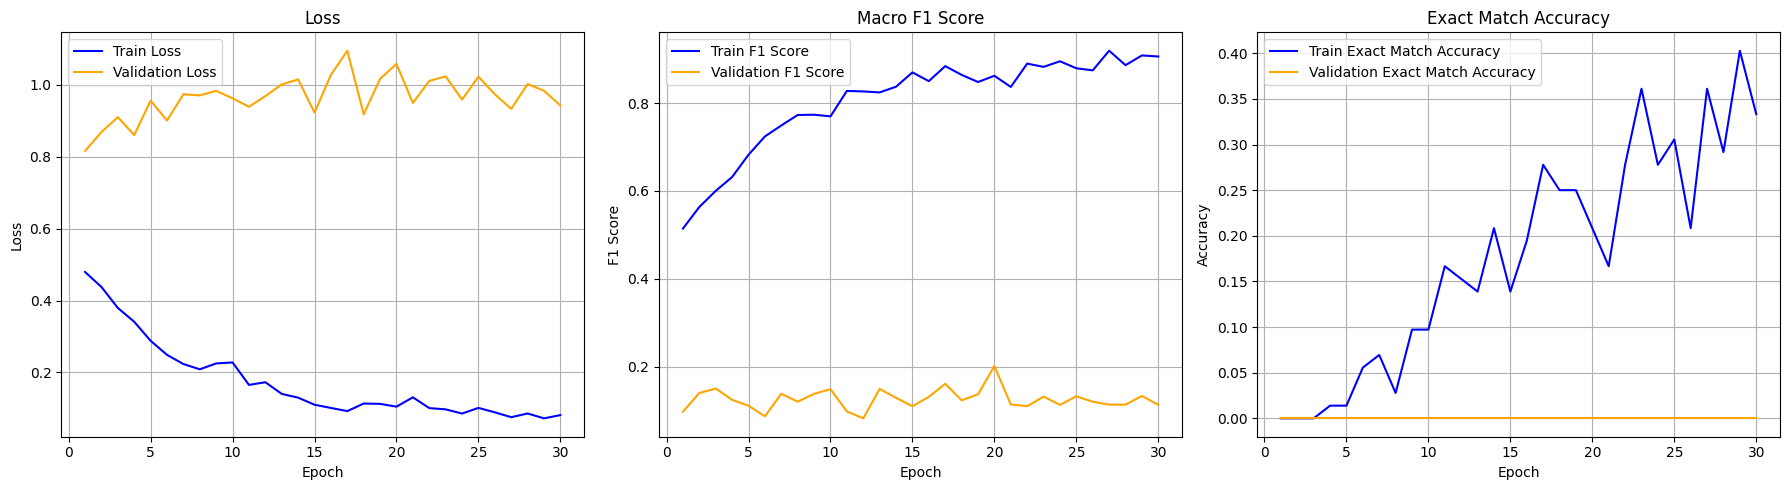

In [28]:
# Plotting training and validation metrics
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.subplot(1, 3, 2)
plt.plot(epochs, train_f1s, label='Train F1 Score', color='blue')
plt.plot(epochs, val_f1s, label='Validation F1 Score', color='orange')
plt.title("Macro F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)

# Plot Exact Match Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, train_exact_acc, label='Train Exact Match Accuracy', color='blue')
plt.plot(epochs, val_exact_acc, label='Validation Exact Match Accuracy', color='orange')
plt.title("Exact Match Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

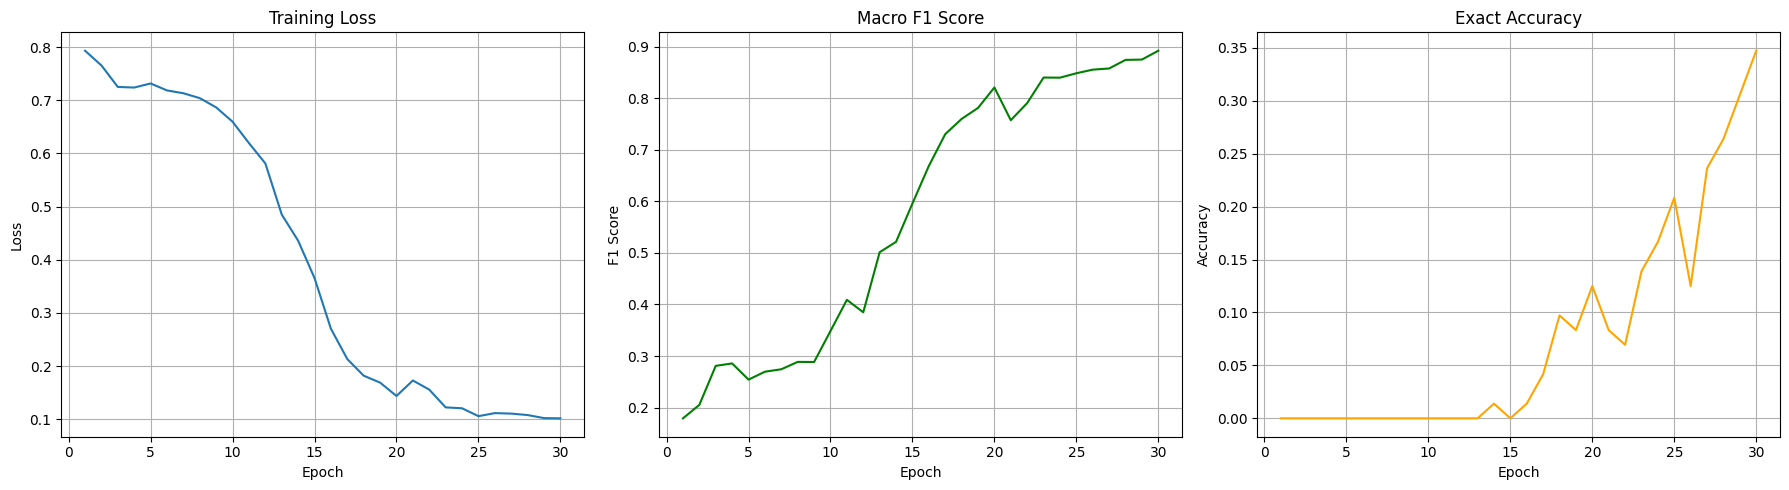

In [38]:
# --- Plotting ---
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, train_f1s, label='F1 Score', color='green')
plt.title("Macro F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, train_exact_acc, label='Exact Match Accuracy', color='orange')
plt.title("Exact Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
          Flatten-10                [-1, 16384]               0
           Linear-11                  [-1, 256]       4,194,560
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                   

In [30]:
# Load the test set IDs from the sample submission file
sample_submission_path = "dataset_project_iapr2025/sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path)
test_ids = sample_submission["id"].tolist()
print(len(test_ids))

labels_df_test = pd.read_csv("dataset_project_iapr2025/sample_submission.csv", index_col="id")

# Create the test dataset and dataloader
test_dataset = ChocolateDataset(
    img_dir="dataset_project_iapr2025/test",
    # df=sample_submission.set_index("id"),  # Use the IDs from the sample submission
    df = labels_df_test,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Switch model to evaluation mode
model.eval()

180


ChocolateCounterCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=13, bias=True)
    (5): ReLU()
  )
)

In [16]:
img_ids_test = test_dataset.img_ids
len(test_dataset.img_ids)

180

In [22]:
test_loader

In [31]:
# Load the sample submission and get test IDs
sample_submission_path = "dataset_project_iapr2025/sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path)
test_ids = sample_submission["id"].tolist()

# Use the sample submission for the test dataframe
labels_df_test = pd.read_csv(sample_submission_path, index_col="id")

# Create the test dataset and dataloader
test_dataset = ChocolateDataset(
    img_dir="dataset_project_iapr2025/test",
    df=labels_df_test,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Switch model to evaluation mode
model.eval()

# List to store predictions
predictions_list = []

with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Generating Test Predictions"):
        images = images.to(device)
        outputs = model(images)
        preds = torch.round(outputs).cpu().numpy().astype(int)
        predictions_list.extend(preds.tolist())

# Ensure the number of predictions matches the number of test IDs
assert len(predictions_list) == len(test_ids), f"Expected {len(test_ids)} predictions but got {len(predictions_list)}"

# Combine test IDs with predictions
submission_df = pd.DataFrame(predictions_list, columns=sample_submission.columns[1:])
submission_df.insert(0, "id", test_ids)

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Generating Test Predictions: 100%|██████████| 23/23 [00:39<00:00,  1.74s/it]

Submission file saved as submission.csv


In [23]:
# Prepare a list to store submission rows
submission_rows = []

# Generate predictions
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Generating Test Predictions"):
        images = images.to(device)
        outputs = model(images)
        predictions = torch.round(outputs).cpu().numpy().astype(int)  # Convert predictions to integers
        targets = labels.detach().cpu().numpy().astype(int)
        print(targets)
        # Map labels back to image IDs
        # img_ids = test_dataset.img_ids  # Access the img_ids from the dataset
        # print(img_ids)

        # Collect rows for the submission
        for img_id, pred in zip (test_ids, predictions):
            submission_rows.append([(img_id)] + pred.tolist())  # Add the image ID and predictions


        # # Collect rows for the submission
        # for label, pred in zip(labels, predictions):
        #     # Get the index of the label in the dataset
        #     label_idx = (labels == label).nonzero(as_tuple=True)[0].item()
        #     img_id = img_ids[label_idx]  # Map label index back to the corresponding image ID
        #     submission_rows.append([img_id] + pred.tolist())  # Add the image ID and predictions

        # for label, pred in zip(labels, predictions):
        #     img_id = img_ids[int(label.argmax())]  # Map label back to the corresponding image ID
        #     submission_rows.append([img_id] + pred.tolist())  # Add the image ID and predictions

# Create the submission DataFrame
submission = pd.DataFrame(submission_rows, columns=sample_submission.columns)

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Generating Test Predictions:   4%|▍         | 1/23 [00:01<00:26,  1.22s/it]

[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


Generating Test Predictions:   9%|▊         | 2/23 [00:02<00:27,  1.30s/it]

[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


Generating Test Predictions:  13%|█▎        | 3/23 [00:03<00:26,  1.34s/it]

[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


Generating Test Predictions:  17%|█▋        | 4/23 [00:05<00:25,  1.34s/it]

[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


Generating Test Predictions:  22%|██▏       | 5/23 [00:06<00:24,  1.35s/it]

[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


Generating Test Predictions:  26%|██▌       | 6/23 [00:08<00:22,  1.35s/it]

[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


Generating Test Predictions:  26%|██▌       | 6/23 [00:08<00:24,  1.43s/it]


KeyboardInterrupt: 

In [72]:
len(submission)

180

In [ ]:
# Prepare a list to store submission rows
submission_rows = []

# Generate predictions
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # print(img_ids)
        images = images.to(device)
        outputs = model(images)
        predictions = torch.round(outputs).cpu().numpy().astype(int)  # Convert predictions to integers
        # img_ids = img_ids.cpu().numpy() if isinstance(img_ids, torch.Tensor) else img_ids

        # Collect rows for the submission
        for img_id, pred in zip(img_ids, predictions):
            submission_rows.append([img_ids] + pred.tolist()) # Format as a row with ID and predictions

# Create the submission DataFrame
submission = pd.DataFrame(submission_rows, columns=sample_submission.columns)

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

  0%|          | 0/23 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:

# Assuming you have a test dataset class similar to ChocolateDataset
class TestDataset(Dataset):
    def __init__(self, img_dir, img_ids, transform=None):
        self.img_dir = img_dir
        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, f"L{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_id

# Load the test set IDs from the sample submission file
sample_submission_path = "dataset_project_iapr2025/sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path)
test_ids = sample_submission["id"].tolist()

# Create the test dataset and dataloader
test_dataset = TestDataset(
    img_dir="dataset_project_iapr2025/test", 
    img_ids=test_ids, 
    transform=transform  # Use the same transform as for training
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Switch model to evaluation mode
model.eval()

# Prepare a DataFrame for the submission
submission = pd.DataFrame(columns=sample_submission.columns)

# Generate predictions
with torch.no_grad():
    for images, img_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        predictions = torch.round(outputs).cpu().numpy().astype(int)  # Round predictions to integers

        # Append predictions to the submission DataFrame
        for img_id, pred in zip(img_ids, predictions):
            submission = submission.append(
                dict(zip(submission.columns, [img_id] + pred.tolist())), 
                ignore_index=True
            )

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

In [10]:
# Training loop
EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")


KeyboardInterrupt: 

In [24]:
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
train_accuracies, val_accuracies = [], []


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_f1, epoch_acc = 0, 0, 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.round(outputs).int().cpu().numpy()
        targets_np = targets.cpu().numpy().astype(int)

        epoch_f1 += f1_score(targets_np, preds, average="macro", zero_division=0)
        epoch_acc += np.mean(np.all(preds == targets_np, axis=1))

    # Average over batches
    train_losses.append(epoch_loss / len(train_loader))
    train_f1s.append(epoch_f1 / len(train_loader))
    train_accuracies.append(epoch_acc / len(train_loader))

    # -------- Validation (if available) --------
    model.eval()
    val_loss, val_f1, val_acc = 0, 0, 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            val_loss += criterion(outputs, targets).item()

            preds = torch.round(outputs).int().cpu().numpy()
            targets_np = targets.cpu().numpy().astype(int)

            val_f1 += f1_score(targets_np, preds, average="macro", zero_division=0)
            val_acc += np.mean(np.all(preds == targets_np, axis=1))

    val_losses.append(val_loss / len(val_loader))
    val_f1s.append(val_f1 / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    print(f"Train F1: {train_f1s[-1]:.4f}, Val F1: {val_f1s[-1]:.4f} | Train Acc: {train_accuracies[-1]*100:.2f}%, Val Acc: {val_accuracies[-1]*100:.2f}%")

# ---------- 📈 Plotting ----------
epochs = range(1, num_epochs+1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.title("Accuracy (Exact Match)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1s, label='Train F1')
plt.plot(epochs, val_f1s, label='Val F1')
plt.title("Macro F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and multilabel-indicator targets